In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, \
 Flatten,BatchNormalization,Activation, GlobalAveragePooling2D, UpSampling2D, Dropout, Lambda
import numpy as np
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
import random

In [ ]:
trainDataset, info = tfds.load('mnist', split='train', with_info=True)

In [ ]:
testDataset = tfds.load('mnist', split='test')

In [ ]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [ ]:
@tf.function
def costIOU(yTrue, yPred):
  wTrue = yTrue[:,1] - yTrue[:,0]
  wPred = tf.maximum(0.0,yPred[:,1] - yPred[:,0])
  mnW_ = tf.minimum(wTrue, wPred)

  hTrue = yTrue[:,3] - yTrue[:,2]
  hPred = tf.maximum(0.0,yPred[:,3] - yPred[:,2])
  mnH_ = tf.minimum(hTrue, hPred)

  mask = yTrue[:,0] >= yPred[:,0]
  
  mxX1 = tf.where(mask,yTrue[:,0], yPred[:,0])
  mnX1 = tf.where(mask, yPred[:,0], yTrue[:,0])
  mnW = tf.where(mask, wPred, wTrue)


  mask2 = yTrue[:,2] >= yPred[:,2]

  mxY1 = tf.where(mask2, yTrue[:,2], yPred[:,2])
  mnY1 = tf.where(mask2, yPred[:,2], yTrue[:,2])
  mnH = tf.where(mask2, hPred, hTrue)

  xOverlap = tf.maximum(0.0, mnX1 + mnW - mxX1)
  yOverlap = tf.maximum(0.0, mnY1 + mnH - mxY1)

  xOverlap = tf.where(xOverlap > mnW_ , mnW_, xOverlap)
  yOverlap = tf.where(yOverlap > mnH_ , mnH_, yOverlap)
  
  # tf.print(xOverlap, yOverlap)

  # print(mnX1)
  intersection = xOverlap * yOverlap
  # tf.print(intersection)
  union = wTrue * hTrue + wPred * hPred - intersection
  iou = intersection / union
  cost = 1 - iou
  return tf.reduce_mean(cost)

SHAPE = (64,64,1)
# SHAPE = (64, 64, 1)
paddedImageConstant = tf.constant(0, shape=SHAPE, dtype=tf.float32)
paddedImage = tf.Variable(paddedImageConstant)
boxVar = tf.Variable([0,0,0,0.0])
def formatImage(data):
  global paddedImage
  image = data['image'] / 255
  label = data['label']
  # print(label)
  sh = image.shape
  r = SHAPE[0] - sh[0]
  c = SHAPE[1] - sh[1]
  rRand = random.random() * r
  cRand = random.random() * c
  r = int(cRand)
  c = int(rRand)
  x1 = r
  y1 = c
  x2 = r + sh[0]
  y2 = c + sh[1]
  x1 = x1 / SHAPE[0]
  y1 = y1 / SHAPE[1]
  x2 = x2 / SHAPE[0]
  y2 = y2 / SHAPE[1]
  paddedImage[0:SHAPE[0], 0:SHAPE[1]].assign(paddedImageConstant)
  paddedImage[r:r+sh[0],c:c+sh[1]].assign(image)
  boxVar[0:4].assign([x1, x2, y1, y2])
  # plt.imshow(paddedImage)
  # return paddedImage_, label
  return paddedImage, (tf.cast(label, dtype=tf.int32), boxVar)

In [ ]:
for i in trainDataset:
  testImage = i['image']
  testLabel = i['label']
  break

In [ ]:
x, y = formatImage({'image' : testImage, 'label' : testLabel})
x, y

(<tf.Variable 'Variable:0' shape=(64, 64, 1) dtype=float32, numpy=
 array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], dtype=float32)>,
 (<tf.Tensor: shape=(), dtype=int32, numpy=4>,
  <tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0.484375, 0.921875, 0.359375, 0.796875], dtype=float32)>))

In [ ]:
costIOU(
    tf.Variable(
        [[6.0, 20,-4, 30]]
        ),
      tf.Variable(
      [[0.0, 10, 0, 8]]
      )
    )

<tf.Tensor: shape=(), dtype=float32, numpy=0.9389313>

In [ ]:
trainFormatted = trainDataset.map(formatImage)
testFormatted = testDataset.map(formatImage)
train = trainFormatted.shuffle(1024).batch(64)
test = testFormatted.shuffle(1024).batch(64)

In [ ]:
def getModel1():
  modelIntermediate1 = Sequential([
                      Conv2D(32, 3, input_shape = SHAPE),
                      # BatchNormalization(),
                      Activation('relu'), 
                      MaxPooling2D(), 
                      Conv2D(32, 3),
                      # BatchNormalization(),
                      Activation('relu'), 
                      MaxPooling2D(), 
                      Conv2D(64, 3),
                      # BatchNormalization(),
                      Activation('relu'), 
                      MaxPooling2D(), 
                      Conv2D(64, 3),
                      # BatchNormalization(),
                      Activation('relu'), 
                      MaxPooling2D() ,
                      # Conv2D(128, 3),
                      # # BatchNormalization(),
                      # Activation('relu'), 
                      # MaxPooling2D()
                      
  ])
  return modelIntermediate1

In [ ]:
def getModel2():
  modelIntermediate2 = Sequential([
                      Conv2D(32, 3, input_shape = SHAPE),
                      # BatchNormalization(),
                      Activation('relu'), 
                      MaxPooling2D(), 
                      Conv2D(64, 3),
                      # BatchNormalization(),
                      Activation('relu'), 
                      MaxPooling2D(), 
                      Conv2D(128, 3),
                      # BatchNormalization(),
                      Activation('relu'), 
                      MaxPooling2D(), 
                      Conv2D(256, 3),
                      # BatchNormalization(),
                      Activation('relu'), 
                      MaxPooling2D() ,
                      # Conv2D(128, 3),
                      # # BatchNormalization(),
                      # Activation('relu'), 
                      # MaxPooling2D()
                      
  ])
  return modelIntermediate2

In [ ]:
input = Input(shape = SHAPE)
x = input
br1 = getModel1()(x)
br2 = getModel2()(x)
br1 = Flatten()(br1)
br1 = Dense(128)(br1)
br1 = BatchNormalization()(br1)
br1 = Activation('relu')(br1)
br1 = Dropout(.24)(br1)
br1 = Dense(10, activation='softmax', name = 'classificationOutput')(br1)
br2 = Conv2D(128, 2, activation='relu')(br2)
br2 = Conv2D(64, 1)(br2)
br2 = BatchNormalization()(br2)
br2 = Activation('relu')(br2)
br2 = Dropout(.2)(br2)
br2 = Conv2D(4, 1, activation='relu')(br2)
br2 = Flatten(name = 'boxOutput')(br2)
model = Model(inputs = input, outputs = [br1, br2])


In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 2, 2, 256)    387840      input_8[0][0]                    
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 2, 2, 64)     64992       input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 1, 1, 128)    131200      sequential_15[0][0]              
____________________________________________________________________________________________

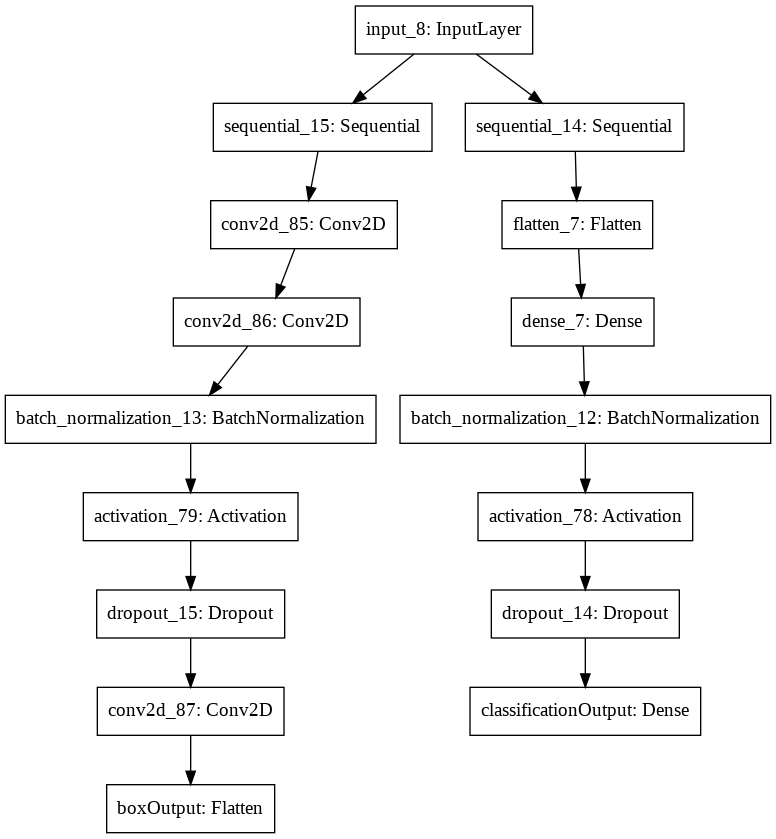

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer='adam', loss = {
    'classificationOutput' : 'sparse_categorical_crossentropy',
    'boxOutput' : 'mse' 
    }, metrics = {'classificationOutput' : 'accuracy', 'boxOutput' : costIOU})

In [ ]:
history = model.fit(train, epochs=10, validation_data=test)

Epoch 1/10
938/938 [==============================] - 58s 60ms/step - loss: 0.3272 - classificationOutput_loss: 0.3154 - boxOutput_loss: 0.0118 - classificationOutput_accuracy: 0.9066 - boxOutput_costIOU: 0.3843 - val_loss: 3.1000 - val_classificationOutput_loss: 3.0851 - val_boxOutput_loss: 0.0150 - val_classificationOutput_accuracy: 0.3201 - val_boxOutput_costIOU: 0.6047
Epoch 2/10
938/938 [==============================] - 60s 64ms/step - loss: 0.0477 - classificationOutput_loss: 0.0473 - boxOutput_loss: 4.2419e-04 - classificationOutput_accuracy: 0.9859 - boxOutput_costIOU: 0.1191 - val_loss: 2.7084 - val_classificationOutput_loss: 2.6947 - val_boxOutput_loss: 0.0137 - val_classificationOutput_accuracy: 0.3367 - val_boxOutput_costIOU: 0.5914
Epoch 3/10
938/938 [==============================] - 59s 63ms/step - loss: 0.0365 - classificationOutput_loss: 0.0364 - boxOutput_loss: 8.6349e-05 - classificationOutput_accuracy: 0.9884 - boxOutput_costIOU: 0.0538 - val_loss: 2.2006 - val_cla

In [ ]:
 t1 = tf.Variable([1, 3, 4, 5])
t2 = tf.Variable([2, 3, 4, 5])

In [ ]:
t1 >= t2

In [ ]:
t1